In [1]:
%run notebook_setup

/home/circleci/project/docs/examples/notebook_setup.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


*If you have not already read it, you may want to start with the first tutorial: [Getting started with The Joker](1-Getting-started.ipynb).*

# Continue generating samples with standard MCMC

When many prior samples are used with *The Joker*, and the sampler returns one sample, or the samples returned are within the same mode of the posterior, the posterior *pdf* is likely unimodal. In these cases, we can use standard MCMC methods to generate posterior samples, which will typically be much more efficient than *The Joker* itself. In this example, we will use `pymc3` to "continue" sampling for data that are very constraining.

First, some imports we will need later:

In [2]:
import astropy.coordinates as coord
import astropy.table as at
from astropy.time import Time
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import corner
import pymc3 as pm
import pymc3_ext as pmx
import exoplanet as xo
import arviz as az

import thejoker as tj

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# set up a random number generator to ensure reproducibility
rnd = np.random.default_rng(seed=42)

Here we will again load some pre-generated data meant to represent well-sampled, precise radial velocity observations of a single luminous source with  a single companion (we again downsample the data set here just for demonstration):

In [4]:
data_tbl = at.QTable.read('data.ecsv')
sub_tbl = data_tbl[rnd.choice(len(data_tbl), size=18, replace=False)]  # downsample data
data = tj.RVData.guess_from_table(sub_tbl, t_ref=data_tbl.meta['t_ref'])

findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


findfont: Generic family 'cursive' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


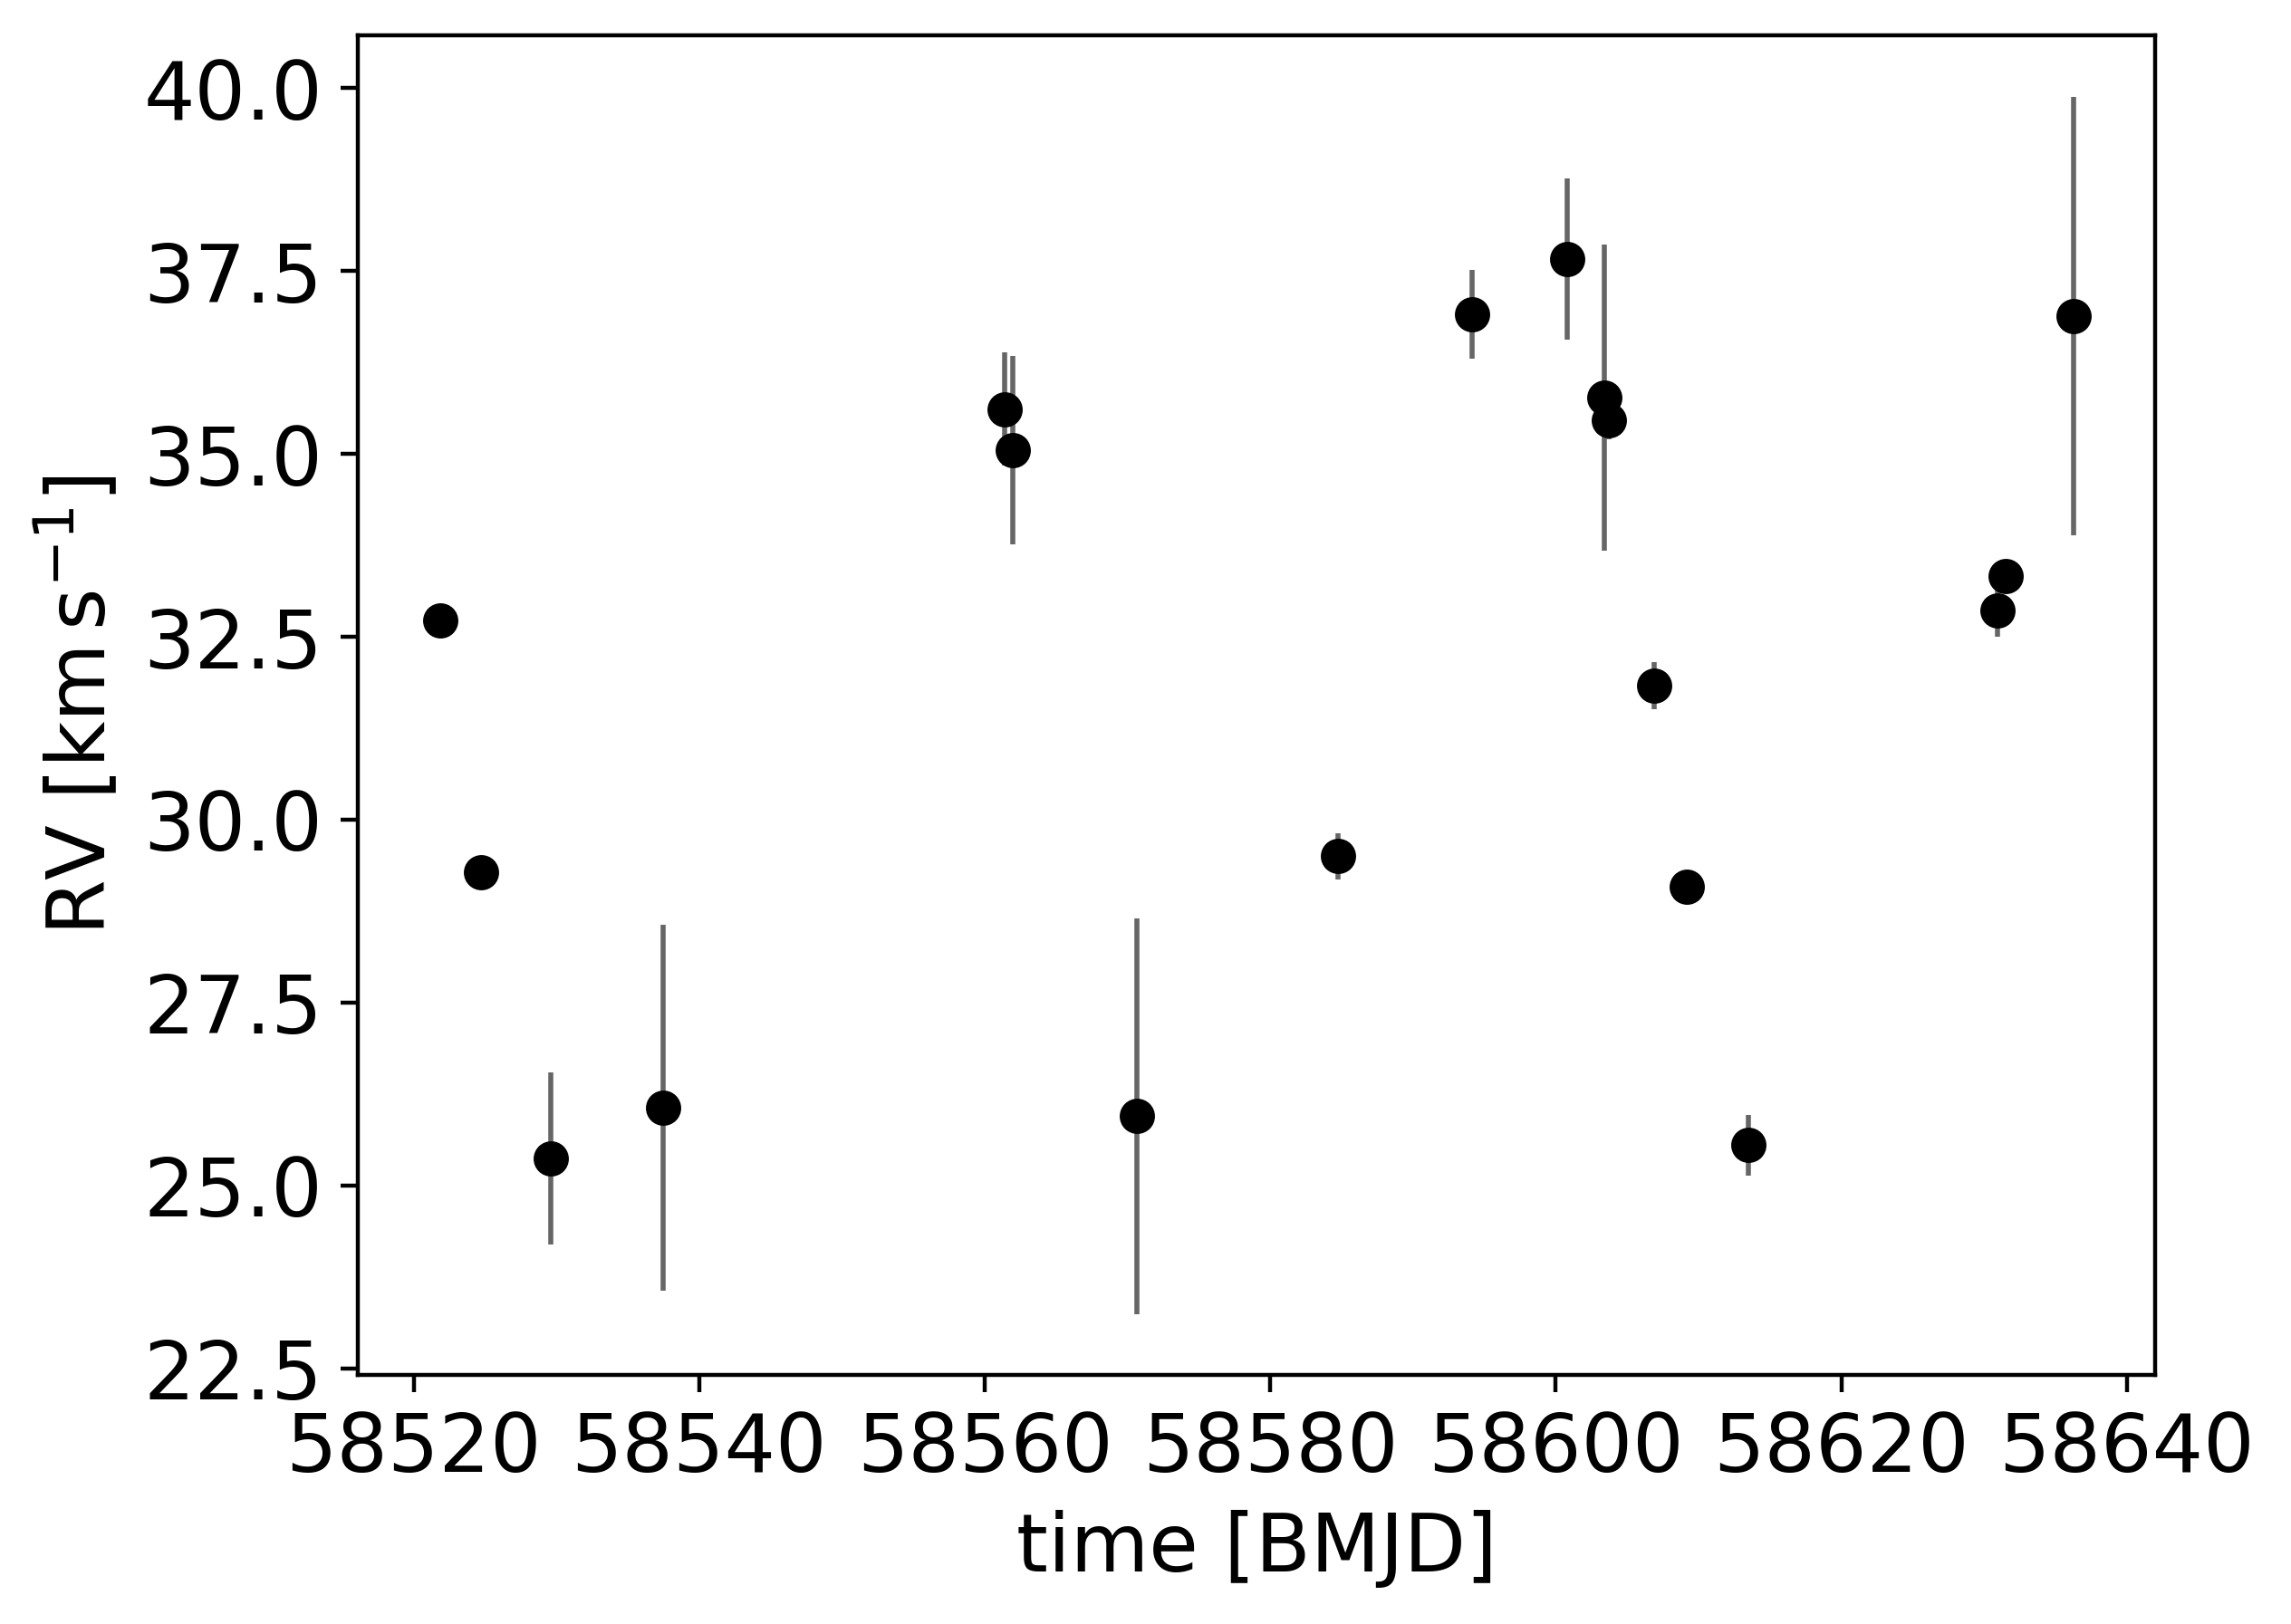

In [5]:
_ = data.plot()

We will use the default prior, but feel free to play around with these values:

In [6]:
prior = tj.JokerPrior.default(
    P_min=2*u.day, P_max=1e3*u.day,
    sigma_K0=30*u.km/u.s,
    sigma_v=100*u.km/u.s)

The data above look fairly constraining: it would be hard to draw many distinct orbital solutions through the RV data plotted above. In cases like this, we will often only get back 1 or a few samples from *The Joker* even if we use a huge number of prior samples. Since we are only going to use the samples from *The Joker* to initialize standard MCMC, we will only use a moderate number of prior samples:

In [7]:
prior_samples = prior.sample(size=250_000, 
                             random_state=rnd)

In [8]:
joker = tj.TheJoker(prior, random_state=rnd)
joker_samples = joker.rejection_sample(data, prior_samples, 
                                       max_posterior_samples=256)
joker_samples

<JokerSamples [P, e, omega, M0, s, K, v0] (1 samples)>

In [9]:
joker_samples.tbl

P,e,omega,M0,s,K,v0
d,,rad,rad,km / s,km / s,km / s
float64,float64,float64,float64,float64,float64,float64
42.53270642939262,0.013562722649362176,1.459681645960666,1.5901030913073155,0.0,7.109996852062445,31.19743584329488


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


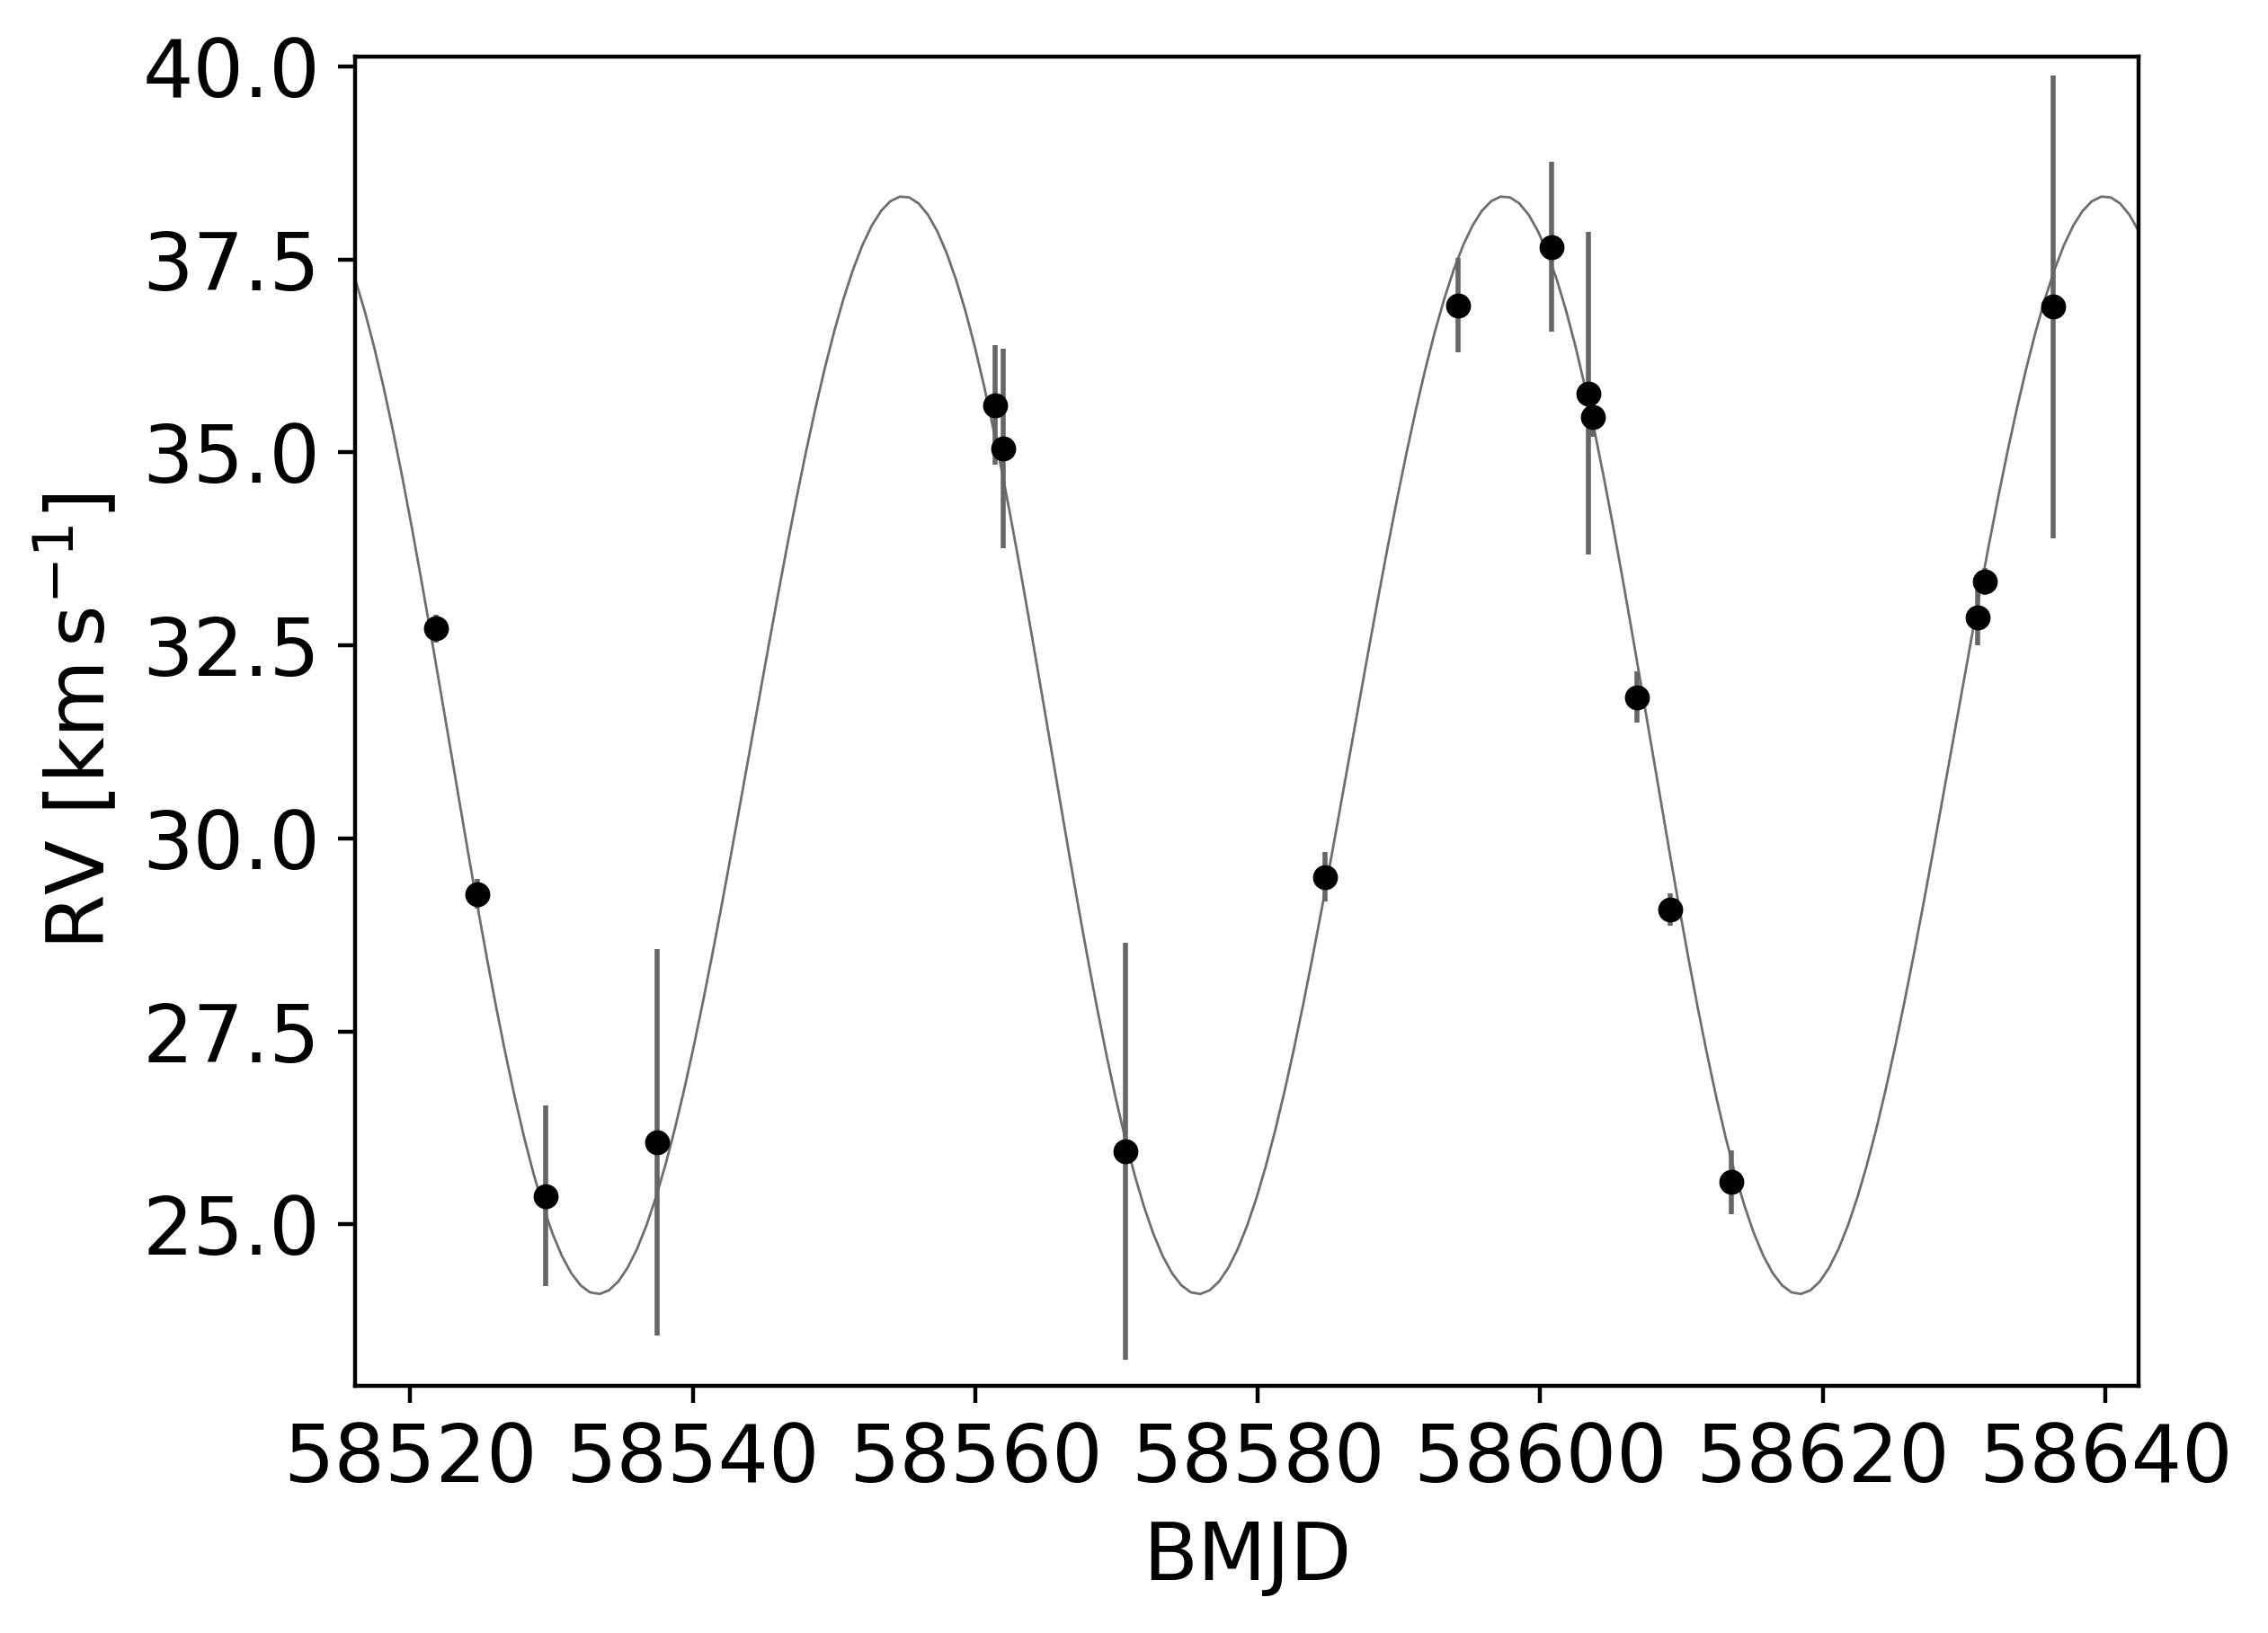

In [10]:
_ = tj.plot_rv_curves(joker_samples, data=data)

The sample that was returned by *The Joker* does look like it is a reasonable fit to the RV data, but to fully explore the posterior *pdf* we will use standard MCMC through `pymc3`. Here we will use the NUTS sampler, but you could also experiment with other backends (e.g., Metropolis-Hastings, or even `emcee` by [following this blog post](https://dfm.io/posts/emcee-pymc3/)):

In [11]:
with prior.model:
    mcmc_init = joker.setup_mcmc(data, joker_samples)
    
    trace = pmx.sample(tune=500, draws=500, 
                       start=mcmc_init,
                       cores=1, chains=2)

Sequential sampling (2 chains in 1 job)


NUTS: [v0, K, P, M0, omega, e]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 21 seconds.


There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


The estimated number of effective samples is smaller than 200 for some parameters.


If you get warnings from running the sampler above, they usually indicate that we should run the sampler for many more steps to tune the sampler and for our main run, but let's ignore that for now. With the MCMC traces in hand, we can summarize the properties of the chains using `pymc3.summary`:

In [12]:
az.summary(trace, var_names=prior.par_names)

Got error No model on context stack. trying to find log_likelihood in translation.


/home/circleci/project/venv/lib/python3.9/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
P,42.153,0.091,41.981,42.315,0.004,0.003,518.0,541.0,1.01
e,0.097,0.028,0.046,0.150,0.001,0.001,481.0,222.0,1.02
omega,1.166,0.339,0.611,1.880,0.025,0.018,178.0,303.0,1.01
M0,1.394,0.324,0.810,2.030,0.024,0.017,178.0,307.0,1.01
s,0.000,0.000,0.000,0.000,0.000,0.000,1000.0,1000.0,NaN
K,6.812,0.280,6.323,7.329,0.011,0.008,619.0,472.0,1.00
v0,31.184,0.178,30.870,31.545,0.010,0.007,321.0,408.0,1.01


To convert the trace into a `JokerSamples` instance, we can use the `TheJoker.trace_to_samples()` method. Note here that the sign of `K` is arbitrary, so to compare to the true value, we also call `wrap_K()` to store only the absolute value of `K` (which also increases `omega` by π, to stay consistent):

In [13]:
mcmc_samples = joker.trace_to_samples(trace, data)
mcmc_samples.wrap_K()
mcmc_samples

/home/circleci/project/thejoker/thejoker.py:492: UserWarning: This method is deprecated: Use thejoker.samples_helpers.trace_to_samples() instead
  warnings.warn(


<JokerSamples [P, e, omega, M0, s, K, v0] (1000 samples)>

We can now compare the samples we got from MCMC to the true orbital parameters used to generate this data:

In [14]:
import pickle
with open('true-orbit.pkl', 'rb') as f:
    truth = pickle.load(f)
    
# make sure the angles are wrapped the same way
if np.median(mcmc_samples['omega']) < 0:
    truth['omega'] = coord.Angle(truth['omega']).wrap_at(np.pi*u.radian)
    
if np.median(mcmc_samples['M0']) < 0:
    truth['M0'] = coord.Angle(truth['M0']).wrap_at(np.pi*u.radian)

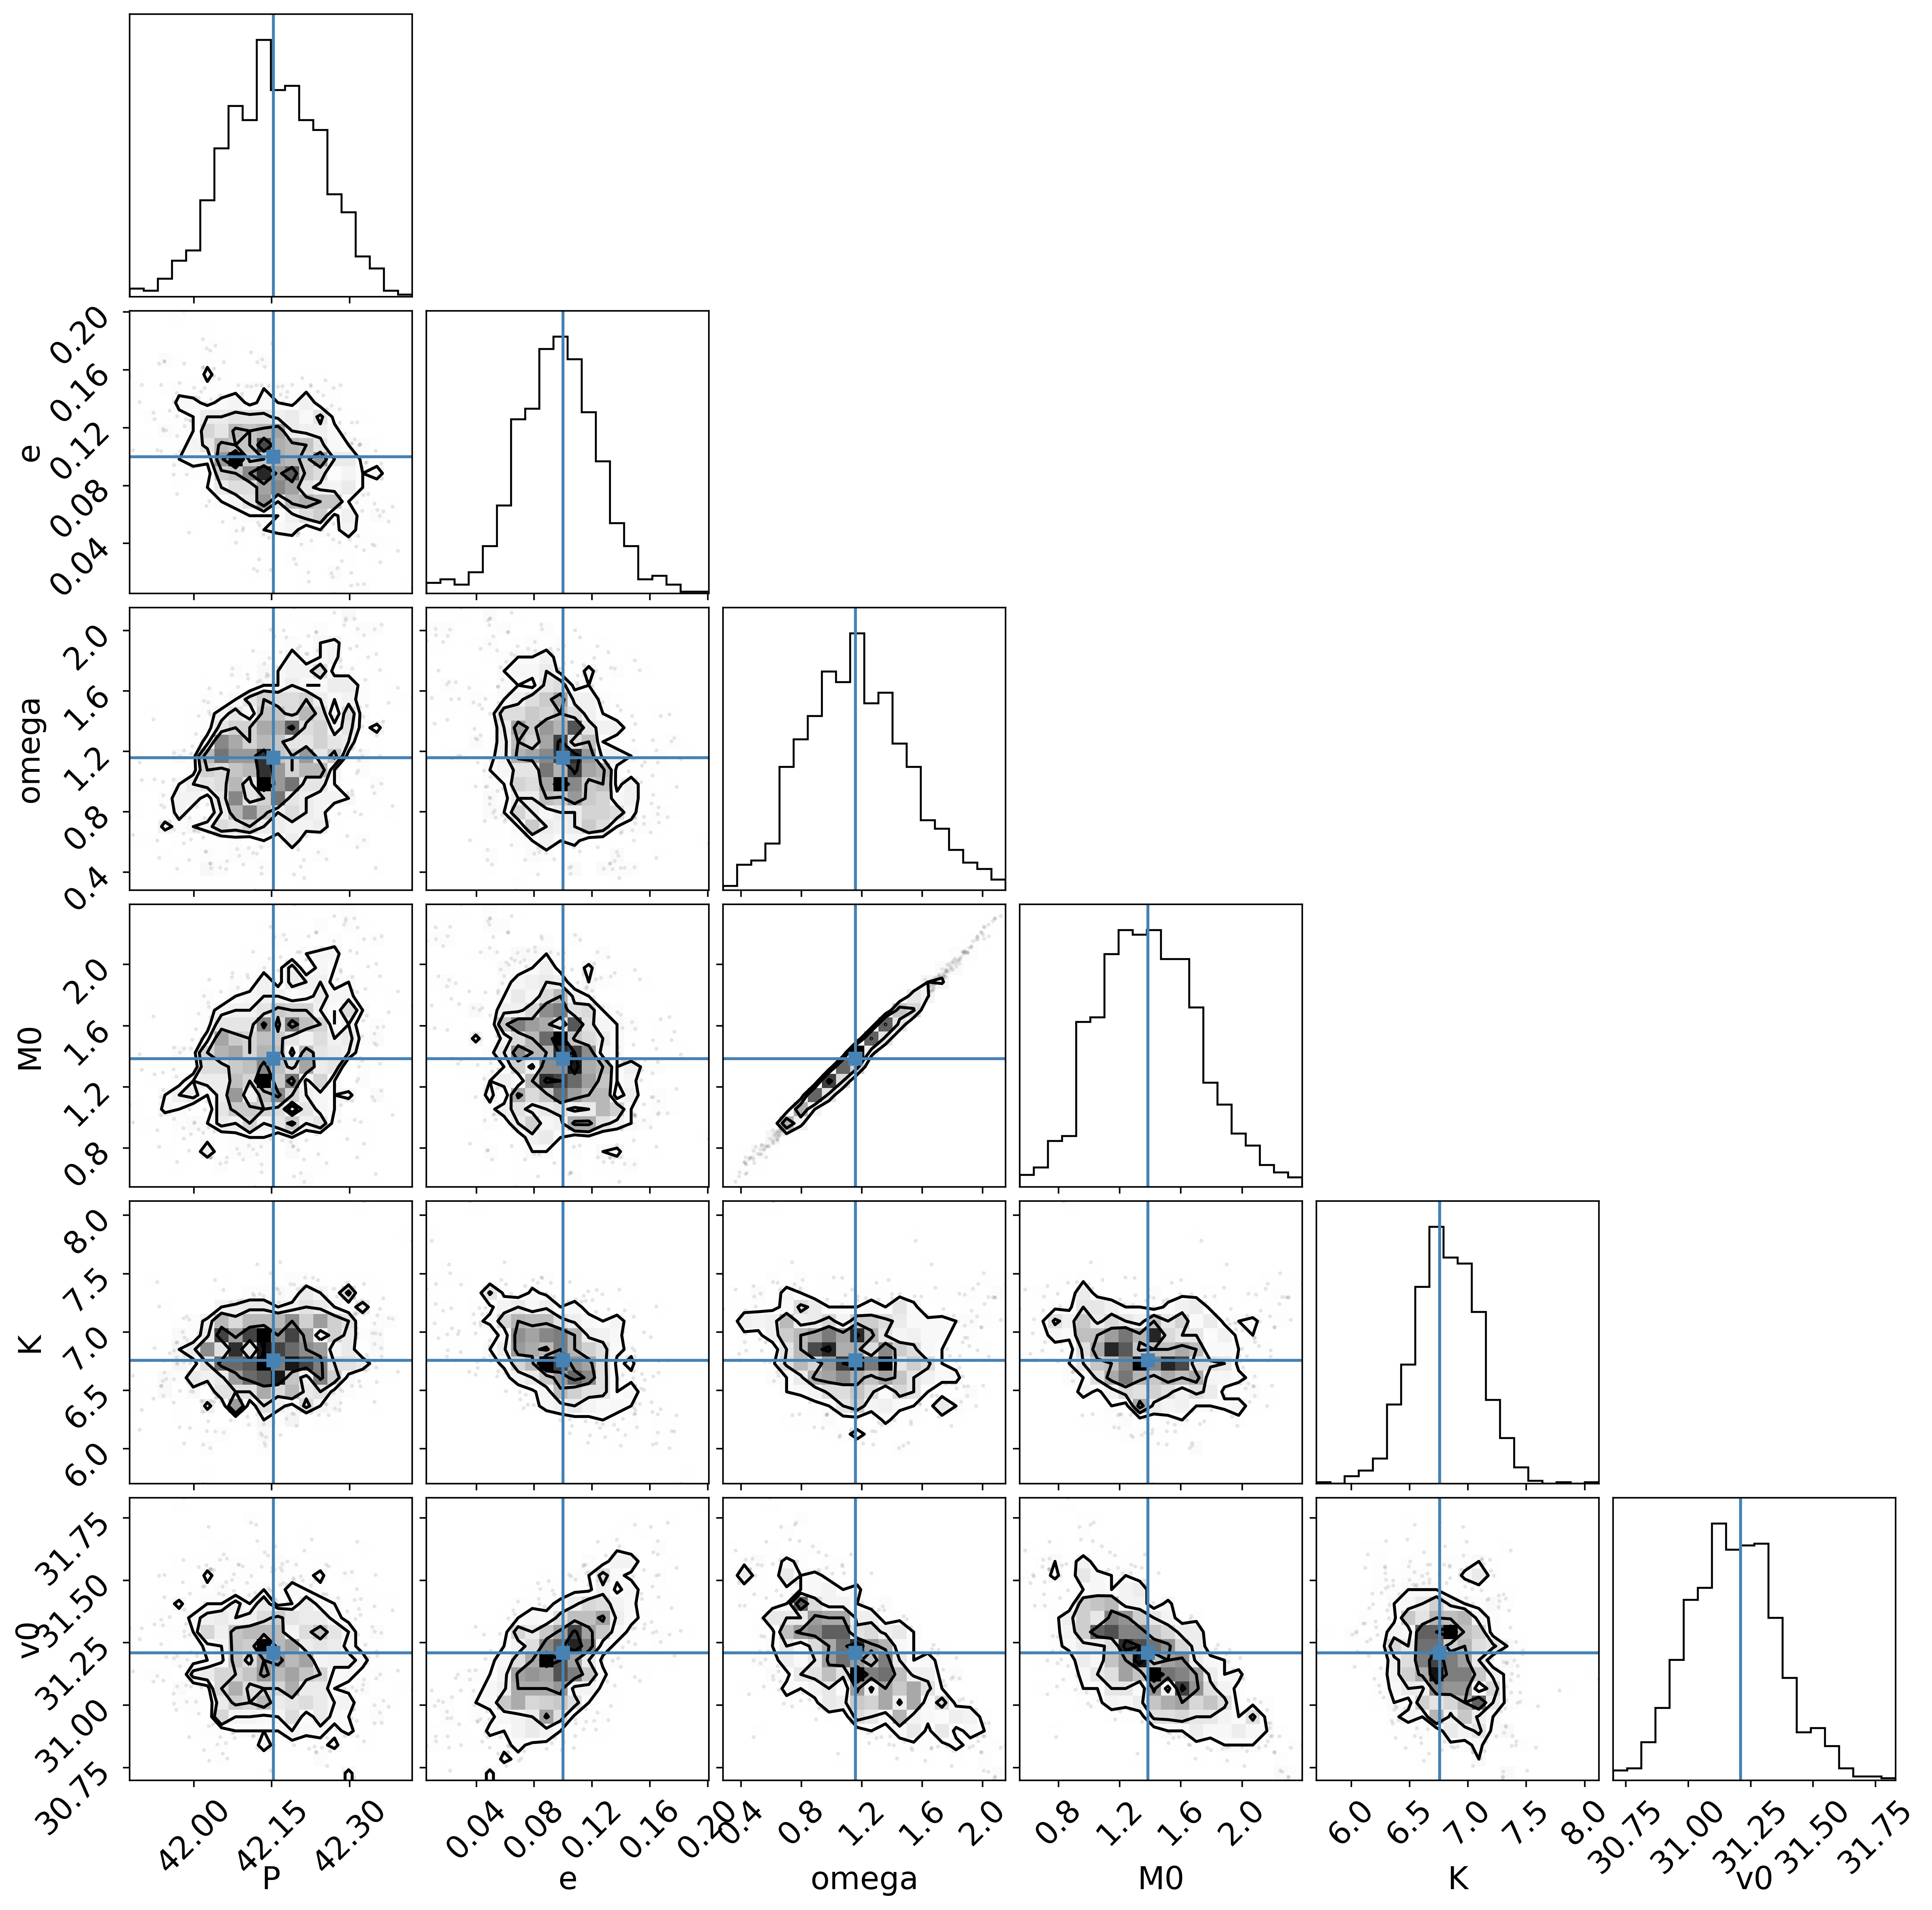

In [15]:
df = mcmc_samples.tbl.to_pandas()
truths = []
colnames = []
for name in df.columns:
    if name in truth:
        colnames.append(name)
        truths.append(truth[name].value)
_ = corner.corner(df[colnames], truths=truths)

Overall, it looks like we do recover the input parameters!